In [1]:
import csv
import math
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from scipy import stats
from dateutil.parser import parse
from datetime import datetime
from IPython.display import display_html
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV

%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

/opt/conda/anaconda/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
######################################################################## ALL USER DEFINED FUNCTION ARE LOGGED HERE #############################################################################
################################################################################################################################################################################################

# calculate rmse scores
def rmse(pred_test, y_test):
    return - np.sqrt(((pred_test - y_test) ** 2).mean())

# calculate mape scores
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# get names of all categorical data present in data
def get_index_of_categorical_columns(df):
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    return list(set(cols) - set(num_cols))


def do_union(lst1, lst2, lst3, lst4): 
    final_list = list(set(lst1) | set(lst2) | set(lst3) | set(lst4))
    return final_list 

In [3]:
################################################################################# USER DEFINED FIELDS ###########################################################################################
#################################################################################################################################################################################################
####### Load ADS using name and path
#### Put name of the file as ads_name : name_of_my_ads
### Put the path is ads name : aes-analytics-0001-notebooks/Outage Restoration/Offshore_Gourav/CSV repo/

load_ads = pd.read_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_OUTAGE_DATASET_V10.4_TRAIN_IQR.csv',index_col=0)
load_ads.head()
print(list(load_ads.columns))

['CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'DAY_FLAG', 'TTR', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 'REGUL

In [4]:
object_columns = load_ads.loc[:, (load_ads.dtypes == object) | (load_ads.dtypes == bool)]
print(list(object_columns.columns))

['DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FL

In [5]:
################################################################################# USER DEFINED FIELDS ###########################################################################################
#################################################################################################################################################################################################

select_columns_from_ads = ['CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'DAY_FLAG', 'TTR', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG',
                           'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                           'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 
                           'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 
                           'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG',
                           'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                           'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 
                           'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 'REGULATOR_OCCURN_FLG', 
                           'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0',
                           'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 'ZONE', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY',
                           'NO_OF_IVR_CLUE_PER_DAY', 'NO_OF_ANIMAL_CAUSE_PER_DAY', 'NO_OF_WIRE_OCCURN_PER_DAY', 'Hour_Sin', 'Hour_Cos', 'RANK_SUBSEQUENT_OUTAGES', 
                           'Outages_in_last_1hr', 'Outages_in_last_2hr', 'Outages_in_last_3hr', 'Outages_in_last_4hr', 'Outages_in_last_5hr', 'Outages_in_last_6hr',
                           'Outages_in_last_7hr', 'Outages_in_last_8hr', 'Outages_in_last_9hr', 'Outages_in_last_10hr', 'Weekday', 'Weekend_flag',
                           'Priority_Customer_Qty', 'Priority_Dist_Customer_Qty', 'Dispatch_Location', 'cldCvrAvg', 'cldCvrMax', 'cldCvrMin', 'dewPtAvg', 
                           'dewPtMax', 'dewPtMin', 'feelsLikeAvg', 'feelsLikeMax', 'feelsLikeMin', 'heatIndexAvg', 'heatIndexMax', 'heatIndexMin', 'mslPresAvg',
                           'mslPresMax', 'mslPresMin', 'precip', 'radSolarAvg', 'radSolarMax', 'radSolarTot', 'relHumAvg', 'relHumMax', 'relHumMin', 'sfcPresAvg', 
                           'sfcPresMax', 'sfcPresMin', 'snowfall', 'spcHumAvg', 'spcHumMax', 'spcHumMin', 'tempAvg', 'tempMax', 'tempMin', 'wetBulbAvg', 'wetBulbMax',
                           'wetBulbMin', 'windChillAvg', 'windChillMax', 'windChillMin', 'windDir100mAvg', 'windDir80mAvg', 'windDirAvg', 'windSpd100mAvg',
                           'windSpd100mMax', 'windSpd100mMin', 'windSpd80mAvg', 'windSpd80mMax', 'windSpd80mMin', 'windSpdAvg', 'windSpdMax', 'windSpdMin', 
                           'tempRange', 'windSpdRange', 'sfcPresRange', 'cldCvrRange', 'relHumRange', 'relHumRatio', 'sfcPresRatio']

ads = load_ads[select_columns_from_ads]

ads = pd.get_dummies(ads, columns=['DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 
                                   'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                                   'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 
                                   'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 
                                   'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 
                                   'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 
                                   'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                                   'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG',
                                   'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 
                                   'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 
                                   'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0', 'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 
                                   'ZONE', 'Weekday', 'Weekend_flag', 'Dispatch_Location'])

# ads.drop(flag_list,axis=1, inplace=True)


# Apply log e tranformation to the dataset
ads['TTR'] = ads['TTR'].apply(lambda x: np.log(x))

In [6]:
# print list of columns present in the ads and drop na's from the dataset
print(list(ads.columns))
ads.dropna(inplace=True)
print(ads.shape)

['CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'TTR', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY', 'NO_OF_IVR_CLUE_PER_DAY', 'NO_OF_ANIMAL_CAUSE_PER_DAY', 'NO_OF_WIRE_OCCURN_PER_DAY', 'Hour_Sin', 'Hour_Cos', 'RANK_SUBSEQUENT_OUTAGES', 'Outages_in_last_1hr', 'Outages_in_last_2hr', 'Outages_in_last_3hr', 'Outages_in_last_4hr', 'Outages_in_last_5hr', 'Outages_in_last_6hr', 'Outages_in_last_7hr', 'Outages_in_last_8hr', 'Outages_in_last_9hr', 'Outages_in_last_10hr', 'Priority_Customer_Qty', 'Priority_Dist_Customer_Qty', 'cldCvrAvg', 'cldCvrMax', 'cldCvrMin', 'dewPtAvg', 'dewPtMax', 'dewPtMin', 'feelsLikeAvg', 'feelsLikeMax', 'feelsLikeMin', 'heatIndexAvg', 'heatIndexMax', 'heatIndexMin', 'mslPresAvg', 'mslPresMax', 'mslPresMin', 'precip', 'radSolarAvg', 'radSolarMax', 'radSolarTot', 'relHumAvg', 'relHumMax', 'relHumMin', 'sfcPresAvg', 'sfcPresMax', 'sfcPresMin', 'snowfall', 'spcHumAvg', 'spcHumMax', 'spcHumMin', 'tempAvg', 'tempMax', 'tempMin', 'wetBulbAvg', 'wetBu

In [ ]:
#########################################################################################################################################################################################################
######################################################################## FEATURE SELECTION : MAX VOTING REGIME ##########################################################################################


X = ads.drop(['TTR'],axis=1)
y = ads['TTR']

xg = xgb.XGBRegressor()
xg.fit(X,y)
rf = RandomForestRegressor()
rf.fit(X,y)
lg = lgb.LGBMRegressor()
lg.fit(X,y)
cb = cb.CatBoostRegressor(silent = True)
cb.fit(X,y)

xgboost = pd.DataFrame({'Features': X.columns, 'Importance_Score_XGBoost': xg.feature_importances_}).sort_values(by='Importance_Score_XGBoost',ascending=False)
rftrees = pd.DataFrame({'Features': X.columns, 'Importance_Score_Random_Forest': rf.feature_importances_}).sort_values(by='Importance_Score_Random_Forest',ascending=False)
lightgbm = pd.DataFrame({'Features': X.columns, 'Importance_Score_Light_GBM': lg.feature_importances_}).sort_values(by='Importance_Score_Light_GBM',ascending=False)
catboost = pd.DataFrame({'Features': X.columns, 'Importance_Score_CatBoost': cb.feature_importances_}).sort_values(by='Importance_Score_CatBoost',ascending=False)
xgboost.reset_index(drop=True,inplace=True)
rftrees.reset_index(drop=True,inplace=True)
lightgbm.reset_index(drop=True,inplace=True)
catboost.reset_index(drop=True,inplace=True)

xgboost = xgboost.head(20)
rftrees = rftrees.head(20)
lightgbm = lightgbm.head(20)
catboost = catboost.head(20)


final_features = do_union(list(xgboost.Features), list(rftrees.Features), list(lightgbm.Features), list(catboost.Features))
print(final_features[:45])

['Outages_in_last_10hr', 'Priority_Dist_Customer_Qty', 'OH_OCCURN_FLG_False', 'DOWNSTREAM_CUST_QTY', 'TREE_CAUSE_FLG_False', 'Outages_in_last_1hr', 'ANIMAL_CAUSE_FLG_True', 'CITY_NAM_NO_CITY', 'PUBLIC_SAFETY_OCCURN_FLG_True', 'windSpd80mMax', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'relHumMax', 'TREE_CAUSE_FLG_True', 'ANIMAL_CAUSE_FLG_False', 'tempRange', 'NO_OF_WIRE_OCCURN_PER_DAY', 'WIRE_OCCURN_FLG_False', 'Priority_Customer_Qty', 'DAY_FLAG_False', 'FUSE_OCCURN_FLG_False', 'UG_CAUSE_FLG_False', 'POWER_OUT_CLUE_FLG_False', 'OPEN_DEVICE_CLUE_FLG_False', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY', 'PUBLIC_SAFETY_OCCURN_FLG_False', 'PUBLIC_CAUSE_FLG_False', 'Hour_Sin', 'Outages_in_last_2hr', 'RANK_SUBSEQUENT_OUTAGES', 'CALL_QTY', 'windSpdRange', 'POLE_CLUE_FLG_False', 'OPEN_DEVICE_CLUE_FLG_True', 'Outages_in_last_6hr', 'Hour_Cos', 'windDirAvg']


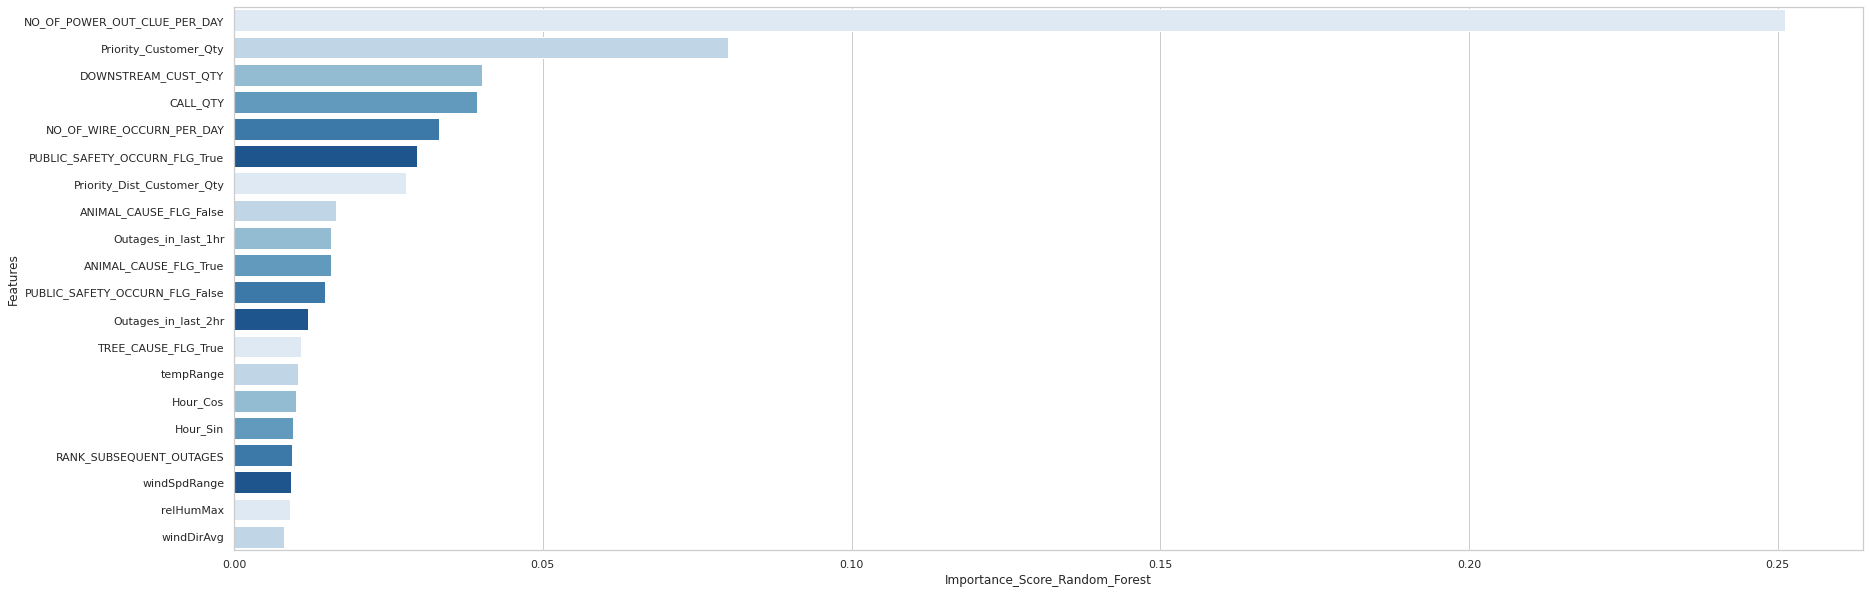

In [15]:
sns.set(rc={'figure.figsize':(26,10)})
sns.set_style("whitegrid")
ax = sns.barplot(x="Importance_Score_Random_Forest", y="Features", data=rftrees, palette = sns.color_palette("Blues"))

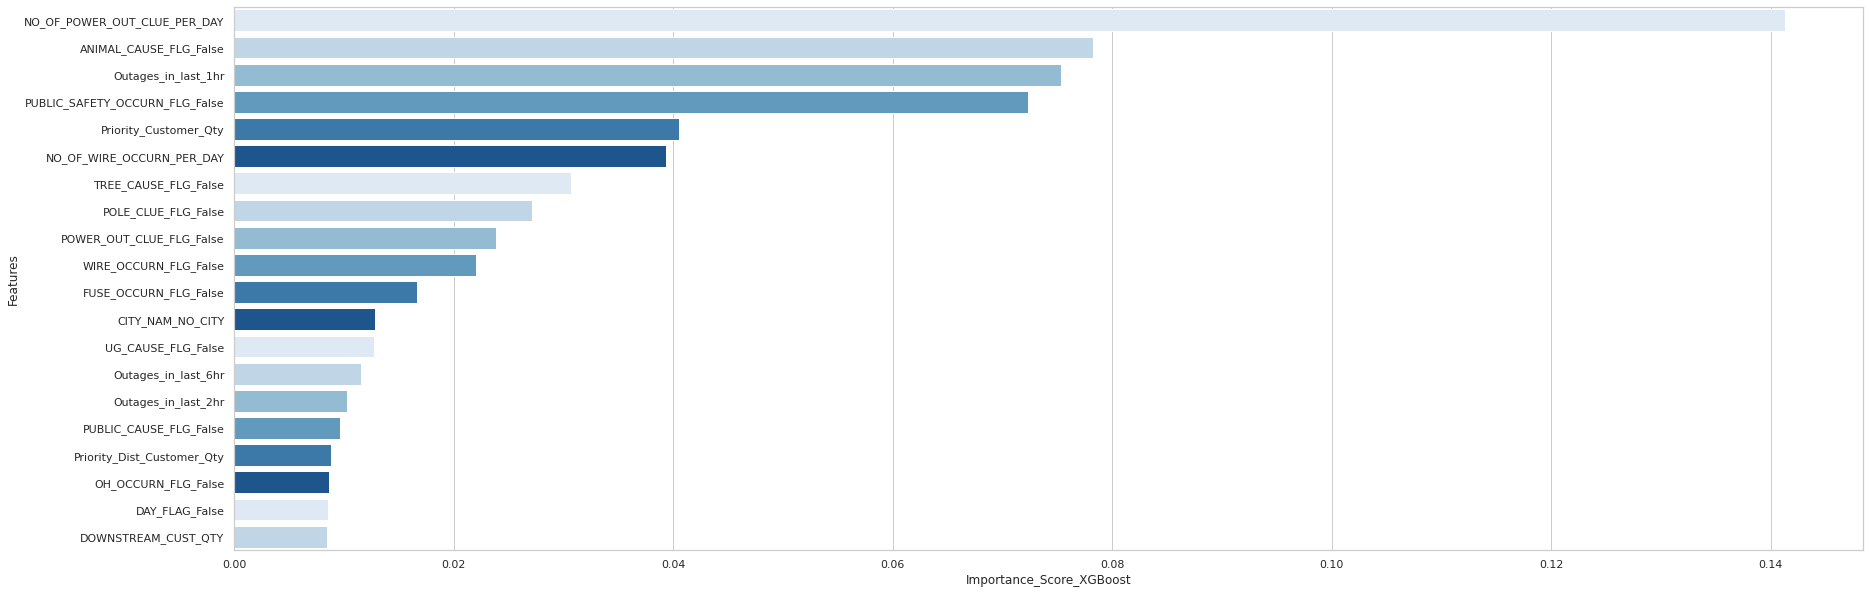

In [16]:
sns.set(rc={'figure.figsize':(26,10)})
sns.set_style("whitegrid")
ax = sns.barplot(x="Importance_Score_XGBoost", y="Features", data=xgboost, palette = sns.color_palette("Blues"))

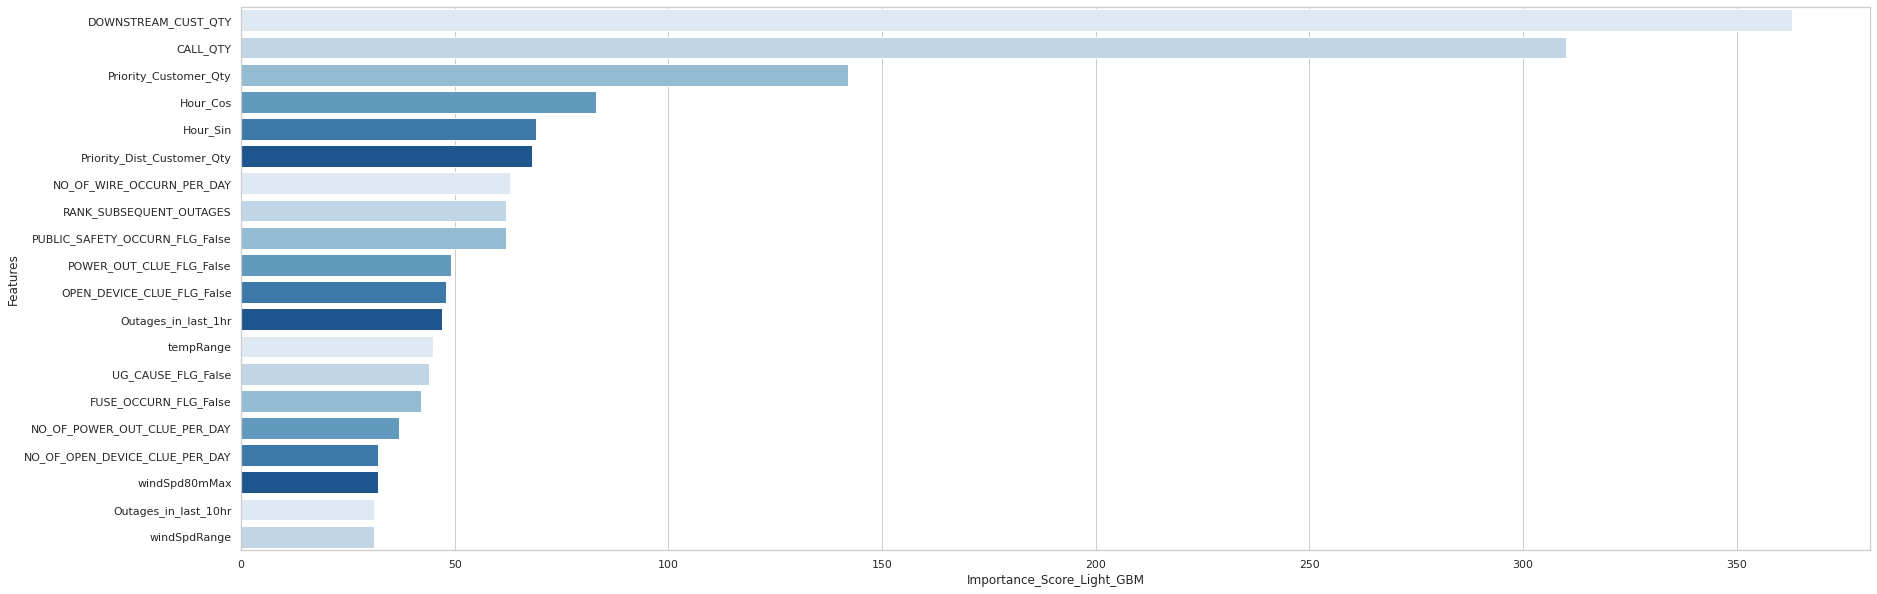

In [17]:
sns.set(rc={'figure.figsize':(26,10)})
sns.set_style("whitegrid")
ax = sns.barplot(x="Importance_Score_Light_GBM", y="Features", data=lightgbm , palette = sns.color_palette("Blues"))

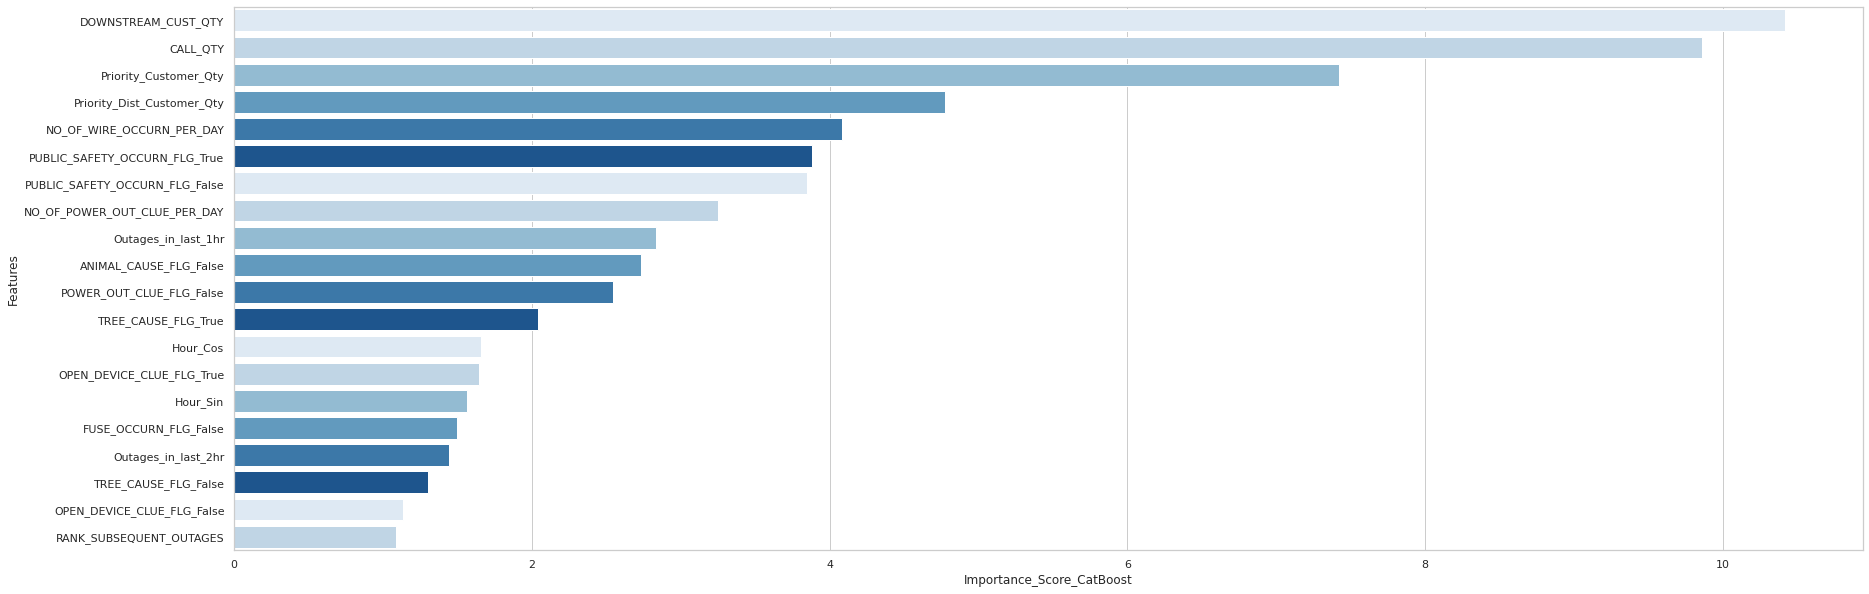

In [18]:
sns.set(rc={'figure.figsize':(26,10)})
sns.set_style("whitegrid")
ax = sns.barplot(x="Importance_Score_CatBoost", y="Features", data=catboost, palette = sns.color_palette("Blues"))

In [ ]:
# Parameters dictionary 

parma_dictionary = { '<ca' : {'depth': [4, 7, 10],'learning_rate' : [0.03, 0.1, 0.15],'l2_leaf_reg': [1,4,9],'iterations': [300]} ,
                     'XGB' : {'max_depth': [10,30,50],'min_child_weight' : [1,3,6],'n_estimators': [200],'learning_rate': [0.05, 0.1,0.16]},
                     'LGB' : {'max_depth': [25,50, 75],'learning_rate' : [0.01,0.05,0.1],'num_leaves': [300,900,1200],'n_estimators': [200, 300]},
                     'Ran' : {"n_estimators" : [300,400], "min_samples_split" : [2,4,8], "max_depth" : [4,8,10]}
                   }

In [20]:
################################################################################# USER DEFINED FIELDS ###########################################################################################
#################################################################################################################################################################################################
# Enter Regression Model Names
# Update Regression Model List 

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import sklearn
from sklearn.cross_decomposition import PLSRegression

lr = sklearn.linear_model.LinearRegression()
pls = PLSRegression()
las = sklearn.linear_model.Lasso()
elas = sklearn.linear_model.ElasticNet()
rf = RandomForestRegressor()
dt = DecisionTreeRegressor()
xgb = xgb.XGBRegressor()
lgb = lgb.LGBMRegressor(verbose_eval = -1)
cb = cb.CatBoostRegressor(silent = True)

regressors = [lr, pls, las, elas, rf, dt, xgb, lgb, cb]

In [21]:
# Define model and other needed metrics using a dataframe
# model result structure
# Store the all iteration results 

model_col = ['MODEL_NAME' , 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'TEST_R2']
model_result_df = pd.DataFrame(columns=model_col)
data_list = pd.DataFrame()     

In [30]:
j=0
from datetime import datetime
for model_names in regressors :
    
# train test Split for Dataset     
    X = ads[final_features]
    y = ads['TTR']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    key = {'LinearRegression()' : "LogisticRegression", 'pls' : "PartialLeastSquare", 'las' : 'Lasso', 'elas' : 'ELasticNet', 'rf' : 'RandomForest', 'dt' : 'DescisionTrees',
           'xgb' : 'XGBoost', 'lgb' : 'LightGradientBoosting', 'cb' : 'CatBoost'}

    print(str(model_names))
    model_name = key.get(str(model_names))
    print(model_name)
    
    model_names.fit(X_train, y_train)    
    y_pred =  model_names.predict(X_test)
    
    date = str(datetime.today().strftime('%Y-%m-%d-%H:%M'))
    filename = str('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/'+model_name+'_'+date'.sav')
    pickle.dump(model, open(filename, 'wb'))
    
    # anti log y_test and y_pred values
    y_test = np.exp(y_test)
    y_pred = np.exp(y_pred)
    
    print("\n")

    mse_test = mean_squared_error(y_test, y_pred)

    rmse_test = np.sqrt(mean_squared_error(y_test,y_pred))

    mae_test = mean_absolute_error(y_test, y_pred)

    mape_test = mean_absolute_percentage_error(y_test,y_pred)
    
    r2_test = r2_score(y_test,y_pred)

    
    data_val = pd.DataFrame({'Model':str(model_name)[:4], 'predicted': y_pred.tolist(),'Actual': y_test.tolist()})
    
    data_list = data_list.append(data_val)
    data_list.reset_index(drop=True, inplace=True)
    
    row = [str(model_name)[:4], mse_test, rmse_test, mae_test, mape_test, r2_test]
    model_result_df.loc[j] = row
    
    j = j + 1

SyntaxError: invalid syntax (<ipython-input-30-14fb6d308bb6>, line 24)

In [ ]:
model_result_df.head()

In [ ]:
data_list.shape